In [1]:
from dask.distributed import Client
from dask_ml.cluster import SpectralClustering
import geopandas as gpd
import hvplot.xarray
import pyproj
from pystac_client import Client as pystac_client
import xarray as xr
from shapely.geometry import box
import numpy as np
import dask.array as da
from scipy import sparse
from sklearn.cluster import SpectralClustering
from dask_ml.cluster import KMeans
from ipywidgets import interact, FloatSlider
import holoviews as hv
hv.extension("bokeh")



## Launch Dask Client
Creating a local Dask client keeps the STAC reads and clustering steps responsive by spreading work across workers.

In [ ]:
cl = Client()
cl

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62111,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:62124,Total threads: 2
Dashboard: http://127.0.0.1:62128/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:62114,


2025-09-30 16:17:28,869 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-c2841f250f4ac16f81c8bfa0b264acb0',) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: <Task ('getitem-c2841f250f4ac16f81c8bfa0b264acb0',) getitem(...)>
new run_spec: Alias(('getitem-c2841f250f4ac16f81c8bfa0b264acb0',)->('array-where-getitem-c2841f250f4ac16f81c8bfa0b264acb0',))
old token: '898199bdc70497ba49d1266350bf2d7c'
new token: ('Alias', ('getitem-c2841f250f4ac16f81c8bfa0b264acb0',), ('array-where-getitem-c2841f250f4ac16f81c8bfa0b264acb0',))
old dependencies: {('where-8ba30225e621bc62543965d2b58b0cfe', 0)}
new depe

## Select Area of Interest
We define a tight bounding box around the grasslands site and display it to confirm the footprint before pulling imagery.

In [4]:
bbox = [24.849829673767093, 56.036640346352655, 24.882316589355472, 56.04725989803104]


geom = box(*bbox)  # minx, miny, maxx, maxy
gdf = gpd.GeoDataFrame({"name": ["bbox"]}, geometry=[geom], crs="EPSG:4326")
gdf.explore()  # requires `pip install geopandas[explore]`

## Search Sentinel-2 STAC Catalog
We query the Element 84 STAC API with dates and cloud constraints to retrieve suitable Sentinel-2 scenes.

In [5]:
catalog = pystac_client.open("https://stac.core.eopf.eodc.eu")
# Search with cloud cover filter
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=["2025-01-30", "2025-05-01"],
        query={"eo:cloud_cover": {"lt": 20}},  # Cloud cover less than 20%
    ).items()
)

print(items)
item = items[1]  # extracting the first item


[<Item id=S2C_MSIL2A_20250420T093051_N0511_R136_T35VLC_20250420T124157>, <Item id=S2A_MSIL2A_20250415T094041_N0511_R036_T35VLC_20250415T155631>, <Item id=S2B_MSIL2A_20250415T093039_N0511_R136_T35VLC_20250415T114145>]


In [6]:
item = items[1]
item

<Item id=S2A_MSIL2A_20250415T094041_N0511_R036_T35VLC_20250415T155631>

## Load Selected Scene


In [11]:
ds = xr.open_dataset(
    item.assets["product"].href,engine="eopf-zarr", chunks='auto', op_mode="analysis", resolution=10
) 

minx, miny, maxx, maxy = bbox
crs = ds.rio.crs

# Clip directly with CRS transform handled by rioxarray
grass_land = ds.rio.clip_box(
    minx=minx,
    miny=miny,
    maxx=maxx,
    maxy=maxy,
    crs="EPSG:4326"
)
grass_land


<xarray.Dataset> Size: 3MB
Dimensions:      (x: 207, y: 125)
Coordinates:
  * x            (x) int64 2kB 366035 366045 366055 ... 368075 368085 368095
  * y            (y) int64 1kB 6213425 6213415 6213405 ... 6212195 6212185
    band         int64 8B ...
    spatial_ref  int64 8B 0
Data variables: (12/15)
    b02          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b03          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b04          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b08          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b01          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b05          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    ...           ...
    b12          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b8a          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    cld          (y, x) uint8 26kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    snw          (y, x) uint8 26kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    scl          (y, x) uint8 26kB dask.array<chunksize=(125, 207), meta=np.ndarray>
    b09          (y, x) float64 207kB dask.array<chunksize=(125, 207), meta=np.ndarray>
Attributes: (34)

In [12]:
grass_land = grass_land.drop_vars(["snw","cld","scl"])


In [13]:
rename_map = {
    "b01": "coastal",
    "b02": "blue",
    "b03": "green",
    "b04": "red",
    "b05": "rededge1",
    "b06": "rededge2",
    "b07": "rededge3",
    "b08": "nir",
    "b8a": "nir_narrow",
    "b09": "water_vapour",
    "b11": "swir1",
    "b12": "swir2",
}

grass_land = grass_land.rename(rename_map)

In [22]:
crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 35N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",27],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32635"]]')

In [23]:
grass_land_da = grass_land.to_array(dim="band")
grass_land_da.attrs["crs"] = crs
grass_land_da

<xarray.DataArray (band: 12, y: 125, x: 207)> Size: 2MB
dask.array<stack, shape=(12, 125, 207), dtype=float64, chunksize=(1, 125, 207), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) int64 2kB 366035 366045 366055 ... 368075 368085 368095
  * y            (y) int64 1kB 6213425 6213415 6213405 ... 6212195 6212185
  * band         (band) object 96B 'blue' 'green' ... 'water_vapour'
    spatial_ref  int64 8B 0
Attributes: (35)

## Preview RGB Composite
A quick RGB render verifies the scene quality before investing time in clustering.

In [24]:

rgb = grass_land_da.sel(band=["red", "green", "blue"])

mins = rgb.min(dim=("x", "y"))  
maxs = rgb.max(dim=("x", "y"))  

rgb_norm = ((rgb - mins) / (maxs - mins)).persist()
rgb_plot = rgb_norm.hvplot.rgb(
    x="x", y="y", bands="band", xlabel="lon", ylabel="lat", title="Sentinel-2 RGB",tiles=True
)

rgb_plot

:Overlay
   .Tiles.I :Tiles   [x,y]
   .RGB.I   :RGB   [x,y]   (R,G,B)

# Clustering EO Data

Clustering land classes helps when you want to discover or refine land-cover types without reliable labeled data. Since we don't have any training data, we can build our own clusters. Spectral clustering is a strong choice because it converts complex similarity relationships (like multi-band pixel affinities) into a space where simple algorithms cleanly separate the true land-cover groups.

See other algorithms at:

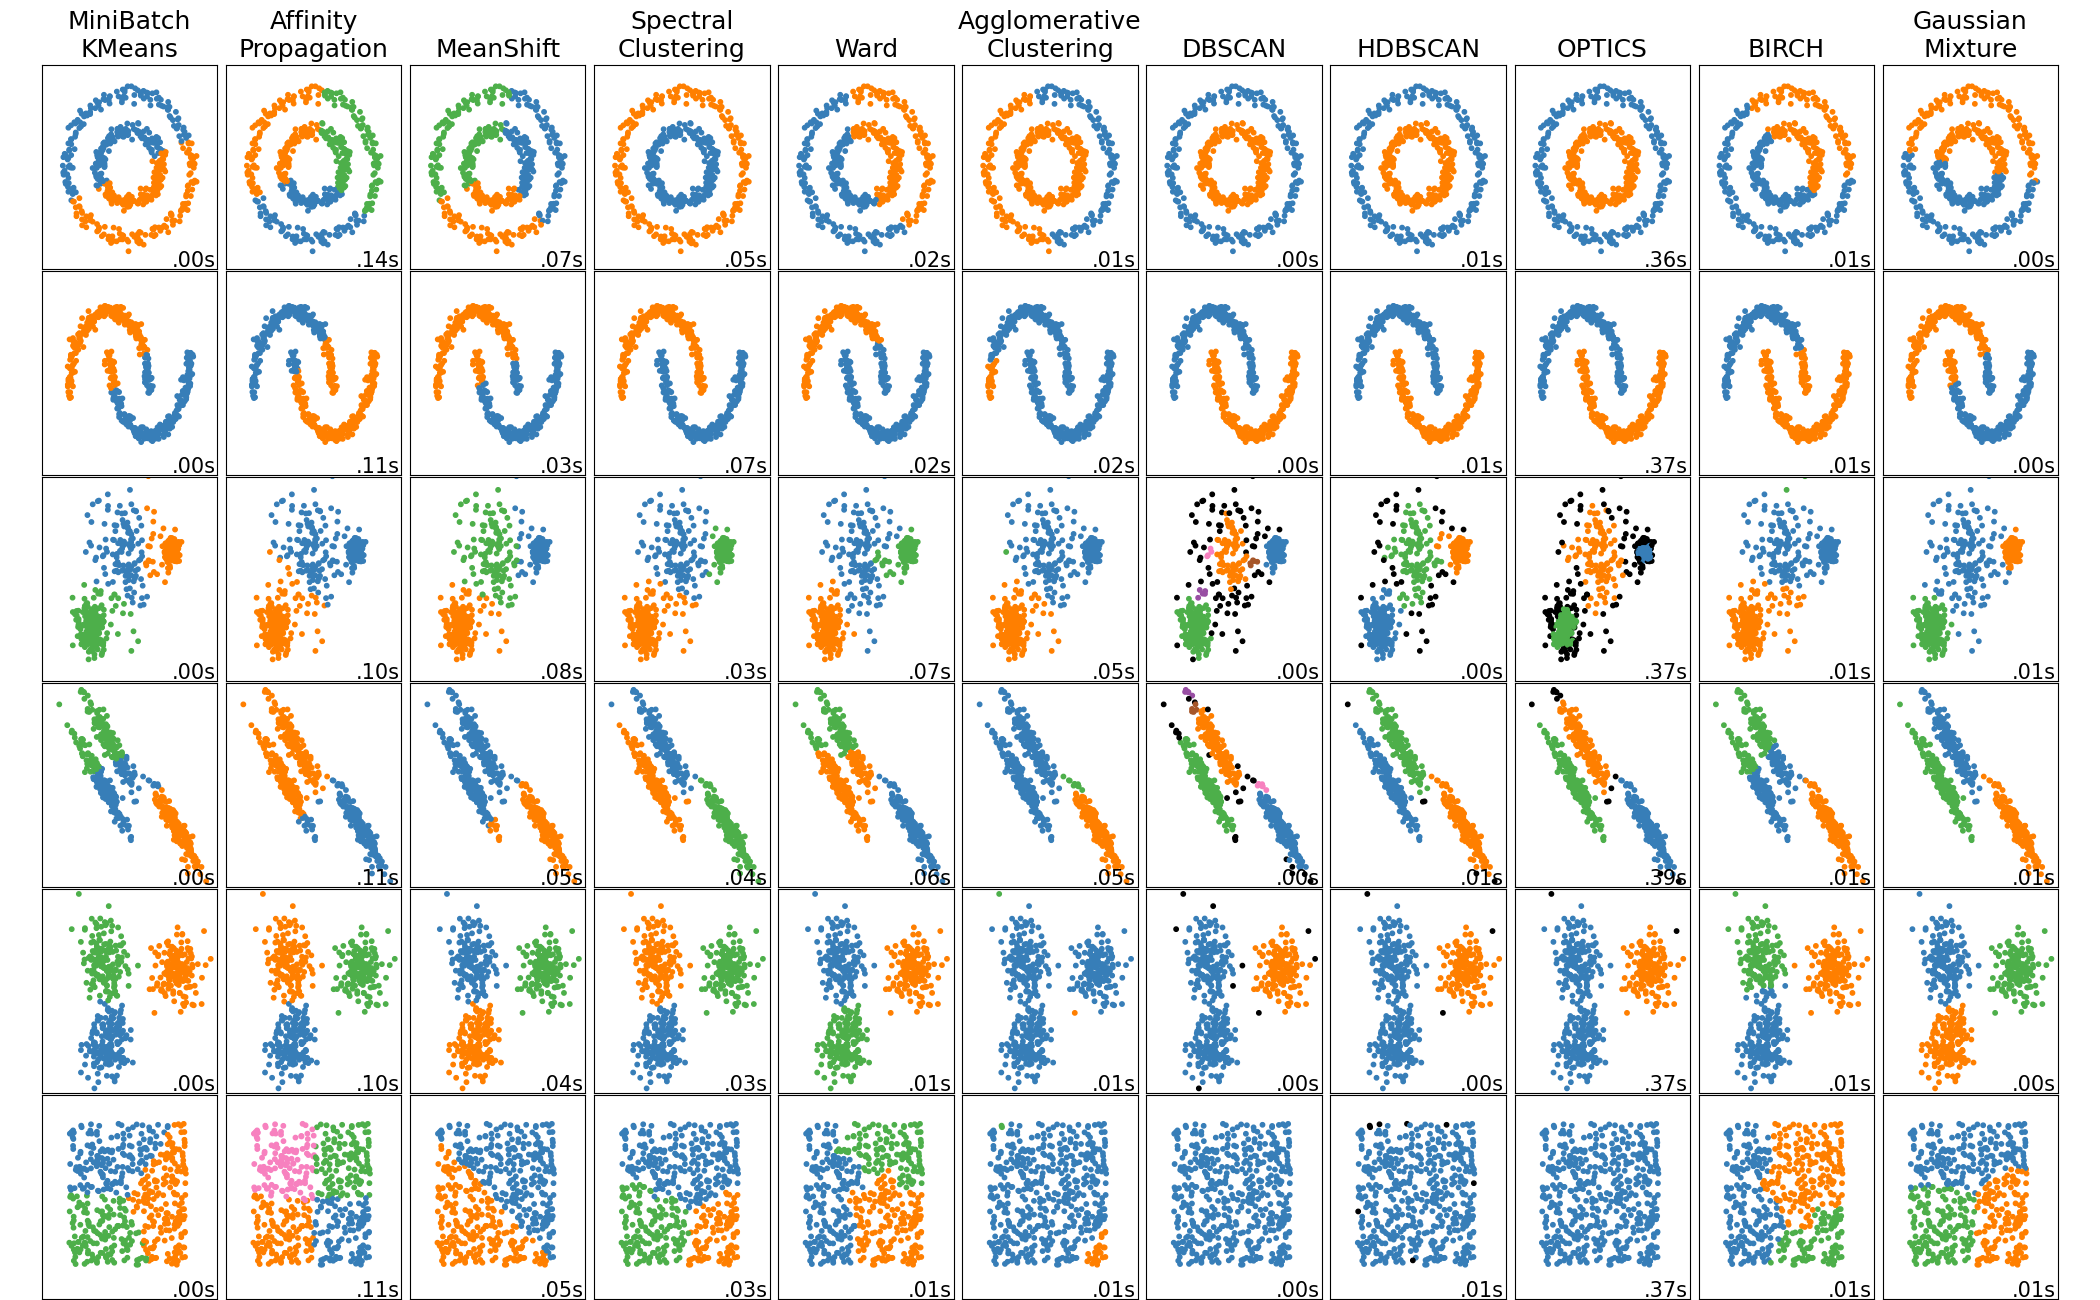
*https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html*


## Spectral clustering pipeline
We standardize each pixel's spectral signature, precompute the affinity matrix based on dask and then run the Sklearn spectral clustering.






### Spectral Clustering Explained Simply
**Step 1 - Represent the data as a network**
We treat each Sentinel-2 pixel in our area of interest as a node. Pixels with similar 13-band signatures form strong edges, so we reason about relationships instead of raw coordinates.

**Step 2 - Find the "smoothest directions" in that network**
We examine the graph Laplacian derived from those connections. Its leading eigenvectors highlight groups of pixels that change smoothly together, exposing land-cover structure such as grass patches versus water.

**Step 3 - Cluster in this new space**
We use those eigenvectors as new features; in this transformed space the classes separate cleanly, so the k-means step inside `SpectralClustering` yields labels we reshape back into a map.



### Prepare Features for Clustering
We collapse the spatial dimensions and standardize band values so spectral clustering can operate on per-pixel feature vectors.

In [25]:
mins = grass_land_da.min(dim=("y", "x"))
maxs = grass_land_da.max(dim=("y", "x"))
grass_land_norm = (grass_land_da - mins) / (maxs - mins + 1e-8)

In [27]:
# SPECTRAL CLUSTERING (NO SCALING OF SPECTRAL CLUSTERING. ONLY ON MATRIX COMPUTATION)
# ----------------------------
#    Weights: w = exp(-||Δspectrum||^2 / (2*sigma^2)),
#    edges only between spatial neighbors (4-neighborhood).
#    Choose sigma as median of ||Δspectrum||^2 over all spatial neighbors.
# ----------------------------
B, H, W = grass_land_norm.sizes["band"], grass_land_norm.sizes["y"], grass_land_norm.sizes["x"]

# East neighbors (columns): compare [:, :, :-1] with [:, :, 1:]
east_diff = grass_land_norm.data[:, :, :-1] - grass_land_norm.data[:, :, 1:]
east_dist2 = (east_diff ** 2).sum(axis=0)  # (y, x-1)

# South neighbors (rows): compare [:, :-1, :] with [:, 1:, :]
south_diff = grass_land_norm.data[:, :-1, :] - grass_land_norm.data[:, 1:, :]
south_dist2 = (south_diff ** 2).sum(axis=0)  # (y-1, x)

# Choose sigma (median)
sample_e = da.random.choice(east_dist2.ravel(), size=min(1_000_000, east_dist2.size), replace=False)
sample_s = da.random.choice(south_dist2.ravel(), size=min(1_000_000, south_dist2.size), replace=False)
sigma2 = da.percentile(da.concatenate([sample_e, sample_s]), 50).compute() + 1e-10
sigma2 = float(sigma2)

east_w = da.exp(-east_dist2 / (2.0 * sigma2)) 
south_w = da.exp(-south_dist2 / (2.0 * sigma2))

east_w = east_w.compute()
south_w = south_w.compute()

N = H * W
def lin_index(y, x):
    return y * W + x

y_e, x_e = np.mgrid[0:H, 0:W-1]
src_e = lin_index(y_e, x_e).ravel()
dst_e = lin_index(y_e, x_e + 1).ravel()
w_e = east_w.ravel()

y_s, x_s = np.mgrid[0:H-1, 0:W]
src_s = lin_index(y_s, x_s).ravel()
dst_s = lin_index(y_s + 1, x_s).ravel()
w_s = south_w.ravel()

row = np.concatenate([src_e, dst_e, src_s, dst_s])
col = np.concatenate([dst_e, src_e, dst_s, src_s])
data = np.concatenate([w_e, w_e, w_s, w_s])

W_sparse = sparse.coo_matrix((data, (row, col)), shape=(N, N)).tocsr()

W_sparse.setdiag(1.0)

n_clusters = 5  
spec = SpectralClustering(
    n_clusters=n_clusters,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=0,
)
labels = spec.fit_predict(W_sparse)  

labels_img = labels.reshape(H, W)

labels_da = xr.DataArray(
    labels_img,
    dims=("y", "x"),
    coords={"y": rgb_norm.coords["y"], "x": rgb_norm.coords["x"]},
    name="spectral_clusters",
)


/var/folders/j3/513qxyhx4l30byl48tz1k1jr0000gn/T/ipykernel_99212/3685692940.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2 = float(sigma2)


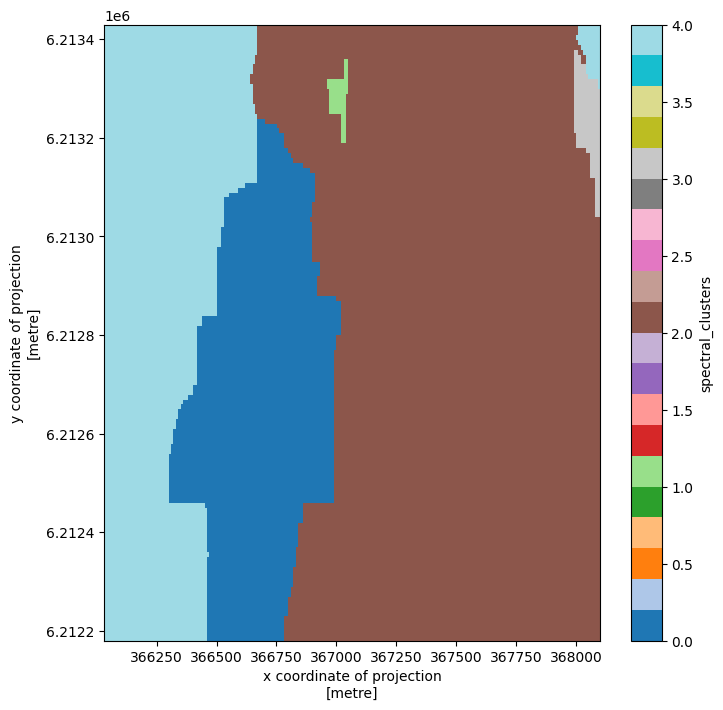

In [28]:
labels_da.plot.imshow(cmap="tab20", figsize=(8, 8))

# TOdo add a k-means that does not take account of spatial info

## KMean Clustering using the Dask version with spectal and spatial features

In [29]:

# KMEAN CLUSTERING (SPECTRAL + SPATIAL FEATURES)
# ----------------------------
#    Features: [scaled_spectrum, scaled_y, scaled_x]
# ----------------------------
B, H, W = [grass_land_norm.sizes[d] for d in ("band","y","x")]
eps = 1e-8

spec_hw_b = grass_land_norm.data.transpose(1,2,0).astype("float32")  
valid2d = da.isfinite(spec_hw_b).all(axis=2)                          
idx = np.flatnonzero(valid2d.ravel().compute())                       

yy, xx = da.meshgrid(da.arange(H), da.arange(W), indexing="ij")
yy = (yy / (H - 1 + eps)).astype("float32")
xx = (xx / (W - 1 + eps)).astype("float32")
spatial_scale = 5.0
spat = da.stack([yy*spatial_scale, xx*spatial_scale], axis=-1)        

X_bands = spec_hw_b.reshape(H*W, B)
X_spat  = spat.reshape(H*W, 2)
Xb_valid = da.take(X_bands, idx, axis=0)  
Xs_valid = da.take(X_spat,  idx, axis=0)  

mu  = Xb_valid.mean(axis=0)
std = Xb_valid.std(axis=0) + 1e-8
Xb_z = (Xb_valid - mu) / std

Xz = da.concatenate([Xb_z, Xs_valid], axis=1).persist()
kmeans = KMeans(n_clusters=8, init_max_iter=10, random_state=0)
Xz = Xz.rechunk({1: Xz.shape[1]})
kmeans.fit(Xz)
labels_valid = kmeans.labels_.compute()
labels_full = np.full(H*W, -1, dtype=np.int32)
labels_full[idx] = labels_valid
labels_img = labels_full.reshape(H, W)

labels_da_spatial = xr.DataArray(
    labels_img, dims=("y","x"),
    coords={"y": grass_land_norm.coords["y"], "x": grass_land_norm.coords["x"]},
    name="kmeans_spectral_spatial",
)

/Users/syam/virtualenvs/myvenv/lib/python3.13/site-packages/dask/base.py:1103: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


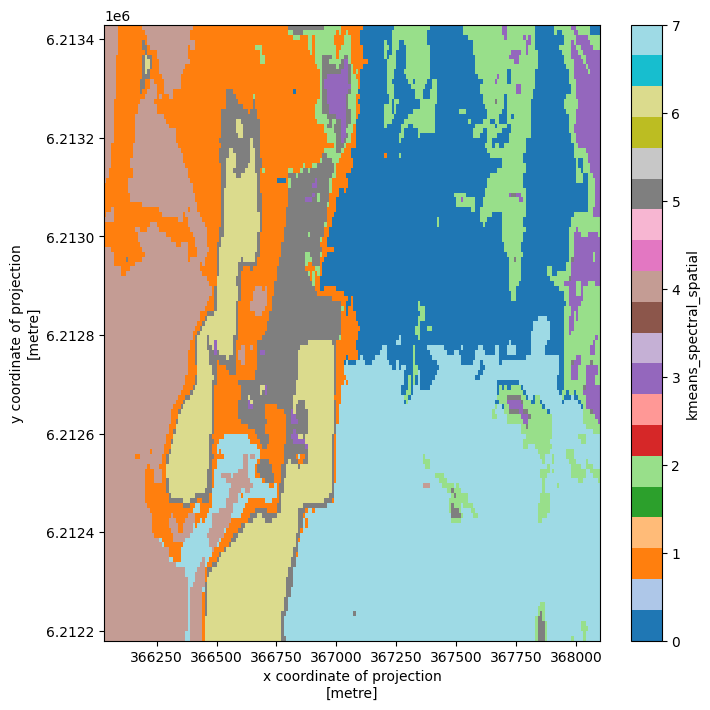

In [30]:
labels_da_spatial.plot.imshow(cmap="tab20", figsize=(8, 8))

## Identify Target Cluster
Sampling the cluster index near a known grassland point lets us isolate the desired class for vectorization.

In [31]:
grass_lon = 3.666e+5
grass_lat = 6.213e+6

proj = pyproj.Proj(grass_land_da.crs)
grass_x, grass_y = proj(grass_lon, grass_lat)

grass = int(labels_da_spatial.sel(x=grass_lon, y=grass_lat, method='nearest').values)

grass
# print('water cluster values:', water_cluster_1988, water_cluster_2017)

6

In [32]:
with xr.set_options(keep_attrs=True):
    grass_cluster = (labels_da_spatial == grass).astype(int)

grass_cluster.hvplot()

:Image   [x,y]   (kmeans_spectral_spatial)

## Visualize Clusters
Overlaying the RGB composite with the cluster map helps sanity-check the segmentation.

In [33]:
def show(alpha=0.3):
    rgb = rgb_norm.hvplot.rgb(
    x="x", y="y", bands="band",
    geo=False, frame_width=800, title="RGB + labels"
    )
    lbl = labels_da_spatial.hvplot.image(
        x="x", y="y",
        geo=False, cmap="tab20",
        alpha=alpha, colorbar=True
    )
    return rgb * lbl

interact(show, alpha=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.3));



interactive(children=(FloatSlider(value=0.3, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

### Next Steps
You can export these polygons or repeat the workflow across multiple dates to track change over time.